## Dynamic model - investigate weighting more recent results higher than older ones

This notebook uses `dynamic_model.stan` to fit home and away scoring rates, weighted by gameweek.

To run, clone the AIrsenal repo, and follow the instructions on the README to install (ensure you have gcc installed, create a conda environment, and do `pip install .` from the main AIrsenal directory).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns

import pandas as pd
from airsenal.framework.utils import *

Couldn't find FPL_LOGIN - some data may be unavailable
Couldn't find FPL_PASSWORD - some data may be unavailable


In [2]:
model = pystan.StanModel(file="dynamic_model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54b0bd22de967cbba493b9fad78a4531 NOW.


In [13]:
rows = []

results = session.query(Result).all()
for result in results:
    row = {}
    row['gameweek'] = result.fixture.gameweek
    row['season'] = result.fixture.season
    row['home_team'] = result.fixture.home_team
    row['away_team'] = result.fixture.away_team
    row['home_goals'] = result.home_score
    row['away_goals'] = result.away_score
    rows.append(row)

df = pd.DataFrame(rows)
df = df.loc[df["season"].isin(["1819", "1718"])]

#df.loc[df["season"] == "1718", "gameweek"] = df.loc[df["season"] == "1718", "gameweek"] + 38
df.loc[df["season"] == "1819", "gameweek"] = df.loc[df["season"] == "1819", "gameweek"] + 38

teams = list(set(df["home_team"]).union(set(df["away_team"])))
team_indices = {team: i + 1 for i, team in enumerate(teams)}

df = df.replace(team_indices)

In [14]:
stan_data = {
    "gameweek": df["gameweek"].values,
    "home_team": df["home_team"].values,
    "away_team": df["away_team"].values,
    "home_goals": df["home_goals"].values,
    "away_goals": df["away_goals"].values,
    "n_match": len(df),
    "n_team": len(teams),
    "n_gameweeks": df["gameweek"].nunique()
}

In [15]:
len(df)

760

In [16]:
fit = model.sampling(stan_data, iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [22]:
def plot_team_ability(team_name, ax=None, param="a"):
    team_idx = team_indices[team_name] - 1
    if ax is None:
        fig, ax = plt.subplots()
    ax.fill_between(
        range(76),
        np.percentile(fit[param][:, team_idx, :], 16, axis=0),
        np.percentile(fit[param][:, team_idx, :], 84, axis=0),
        color="0.5",
        alpha=0.5
    )
    ax.plot(range(76), fit[param][:, team_idx, :].mean(axis=0), c="k")
    return ax

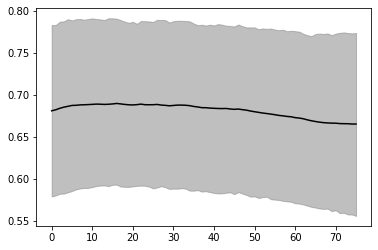

In [23]:
plot_team_ability("MCI")

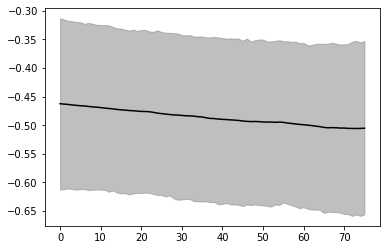

In [24]:
plot_team_ability("MCI", param="b")